In [1]:

import numpy as np # linear algebra
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/career-con-2019/sample_submission.csv
/kaggle/input/career-con-2019/X_test.csv
/kaggle/input/career-con-2019/y_train.csv
/kaggle/input/career-con-2019/X_train.csv
/kaggle/input/career-con-2019-preprocessed-data/encoder.model
/kaggle/input/career-con-2019-preprocessed-data/feat.npy
/kaggle/input/career-con-2019-preprocessed-data/feat_fft.npy
/kaggle/input/career-con-2019-preprocessed-data/target.npy


In [2]:
X_train = pd.read_csv('../input/career-con-2019/X_train.csv')
y_train = pd.read_csv('../input/career-con-2019/y_train.csv')
X_train = pd.merge(X_train,y_train,on='series_id')
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_train['surface'] = le.fit_transform(X_train['surface'])

In [3]:
cols = list(X_train.columns.values)
cols.remove('orientation_W')
cols.insert(3,'orientation_W')
print(cols)

['row_id', 'series_id', 'measurement_number', 'orientation_W', 'orientation_X', 'orientation_Y', 'orientation_Z', 'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 'group_id', 'surface']


In [4]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,2
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,2
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,2
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,2
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,2


In [5]:
X_train = X_train[cols]

In [6]:
X_train.head()

,row_id,series_id,measurement_number,orientation_W,orientation_X,orientation_Y,orientation_Z,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.10597,-0.75853,-0.63435,-0.10488,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,2
1,0_1,0,1,-0.10600,-0.75853,-0.63434,-0.10490,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,2
2,0_2,0,2,-0.10597,-0.75853,-0.63435,-0.10492,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,2
3,0_3,0,3,-0.10597,-0.75852,-0.63436,-0.10495,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,2
4,0_4,0,4,-0.10596,-0.75852,-0.63435,-0.10495,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,2


In [7]:
num_meas = 128
num_series = X_train['series_id'].nunique()
print(num_meas,num_series)

128 3810


In [8]:


def q_to_angle(q_val):
    #We assume q_val is in this format: [qw, q1, q2, q3]
    #And the quaternion is normalized
    roll = np.arctan2(2*(q_val[0]*q_val[1] + q_val[2]*q_val[3]),1 - 2*(q_val[1]*q_val[1] + q_val[2]*q_val[2]))
    pitch = np.arcsin(2*(q_val[0]*q_val[2] - q_val[3]*q_val[1]))
    yaw = np.arctan2(2*(q_val[0]*q_val[3] + q_val[1]*q_val[2]),1 - 2*(q_val[2]*q_val[2] + q_val[3]*q_val[3]))
    return np.array([roll, pitch, yaw])


quat_arr = np.array(X_train[['orientation_W','orientation_X','orientation_Y','orientation_Z']])

euler_arr = np.zeros([quat_arr.shape[0],3])
for n,arr in enumerate(quat_arr):
    euler_arr[n] = q_to_angle(arr)

X_train['roll'] = euler_arr[:,0]
X_train['pitch'] = euler_arr[:,1]
X_train['yaw'] = euler_arr[:,2]

In [9]:
cols = list(X_train.columns.values)
cols.remove('group_id')
cols.append('group_id')
cols.remove('surface')
cols.append('surface')
X_train = X_train[cols]

In [10]:
feat_cols = ['roll','pitch','yaw','angular_velocity_X','angular_velocity_Y','angular_velocity_Z','linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z']
feat_array = np.array(X_train[feat_cols])
feat_array = np.reshape(feat_array,[num_series,128,len(feat_cols)])
group_array = np.array(X_train['group_id'])
group_array = np.reshape(group_array,[num_series,128])
group_array = group_array[:,0]
target_array = np.array(X_train['surface'])
target_array = np.reshape(target_array,[num_series,128])
target_array = target_array[:,0]


In [11]:
#Normalize each 128-pt sample to ensure there is no group related information left in the samples
norm_cols = ['linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z','angular_velocity_X','angular_velocity_Y','angular_velocity_Z']
for norm in norm_cols:
    iia = feat_cols.index(norm)
    np_arr = feat_array[:,:,iia]
    mean_arr = np.mean(np_arr,1)
    mean_arr = np.expand_dims(mean_arr,1)
    mean_arr = np.repeat(mean_arr,num_meas,1)
    np_arr = np_arr - mean_arr
    feat_array[:,:,iia] = np_arr

In [12]:
def absfft(x):
    return np.abs(np.fft.rfft(x))

feat_fft_array = np.copy(feat_array[:,:,3:])
feat_fft_array = np.apply_along_axis(absfft,1,feat_fft_array)

In [13]:
num_sensor = feat_array.shape[2]
for i in range(num_sensor):
    mean_s = np.mean(feat_array[:,:,i])
    sd_s = np.std(feat_array[:,:,i])
    feat_array[:,:,i] = (feat_array[:,:,i]-mean_s)/sd_s

num_sensor_fft = feat_fft_array.shape[2]
for i in range(num_sensor_fft):
    mean_s = np.mean(feat_fft_array[:,:,i])
    sd_s = np.std(feat_fft_array[:,:,i])
    feat_fft_array[:,:,i] = (feat_fft_array[:,:,i]-mean_s)/sd_s

In [14]:
from pathlib import Path
# from sklearn.externals import joblib
from textwrap import dedent

ROOT = Path.cwd().parent/'input'/'career-con-2019-preprocessed-data'
# enc = joblib.load(ROOT/'encoder.model')
raw_arr = np.load(ROOT/'feat.npy').transpose(0, 2, 1)
fft_arr = np.load(ROOT/'feat_fft.npy').transpose(0, 2, 1)
target = np.load(ROOT/'target.npy')
print(dedent(f'''
Dataset shapes:
    raw: {raw_arr.shape}
    fft: {fft_arr.shape}
    target: {target.shape}
'''))


Dataset shapes:
    raw: (7626, 9, 128)
    fft: (7626, 6, 65)
    target: (7626,)



In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader

In [16]:
def create_datasets(data, target, train_size, valid_pct=0.1, seed=None):
    raw, fft = data
    sz = train_size
    idx = np.arange(sz)
    trn_idx, val_idx = train_test_split(
        idx, test_size=valid_pct, random_state=seed)
    trn_ds = TensorDataset(
        torch.tensor(raw[:sz][trn_idx]).float(), 
        torch.tensor(fft[:sz][trn_idx]).float(), 
        torch.tensor(target[:sz][trn_idx]).long())
    val_ds = TensorDataset(
        torch.tensor(raw[:sz][val_idx]).float(), 
        torch.tensor(fft[:sz][val_idx]).float(), 
        torch.tensor(target[:sz][val_idx]).long())
    tst_ds = TensorDataset(
        torch.tensor(raw[sz:]).float(), 
        torch.tensor(fft[sz:]).float(), 
        torch.tensor(target[sz:]).long())
    return trn_ds, val_ds, tst_ds

In [17]:
def create_loaders(data, bs=128, jobs=0):    
    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    return trn_dl, val_dl, tst_dl

In [18]:
class _SepConv1d(nn.Module):
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

In [19]:
class SepConv1d(nn.Module):
    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)

In [20]:
class Flatten(nn.Module):
    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

In [21]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, fft_ni, no, drop=.5):
        super().__init__()
        
        self.raw = nn.Sequential(
            SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
            SepConv1d(    32,  64, 8, 4, 2, drop=drop),
            SepConv1d(    64, 128, 8, 4, 2, drop=drop),
            SepConv1d(   128, 256, 8, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))
        
        self.fft = nn.Sequential(
            SepConv1d(fft_ni,  32, 8, 2, 4, drop=drop),
            SepConv1d(    32,  64, 8, 2, 4, drop=drop),
            SepConv1d(    64, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 256, 8, 2, 3),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))
        
        self.out = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
        
    def forward(self, t_raw, t_fft):
        raw_out = self.raw(t_raw)
        fft_out = self.fft(t_fft)
        t_in = torch.cat([raw_out, fft_out], dim=1)
        out = self.out(t_in)
        return out

In [22]:
trn_sz = 3810

In [23]:
datasets = create_datasets((raw_arr, fft_arr), target, trn_sz, seed=np.random.seed(1))

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [28]:
raw_feat = raw_arr.shape[1]
fft_feat = fft_arr.shape[1]

trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=256)

lr = 0.001
n_epochs = 3000
iterations_per_epoch = len(trn_dl)
num_classes = 9
best_acc = 0
patience, trials = 500, 0
base = 1
step = 2
loss_history = {"train": [], "test": []}
acc_history = {"train": [], "test": []}

model = Classifier(raw_feat, fft_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    correct, total = 0, 0
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        opt.zero_grad()
        out = model(x_raw, x_fft)
        loss = criterion(out, y_batch)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= trn_sz
    acc = correct / total
    loss_history['train'].append(loss.item())
    acc_history["train"].append(acc)
    
    model.eval()
    correct, total = 0, 0
    for batch in val_dl:
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        out = model(x_raw, x_fft)
        loss = criterion(out, y_batch)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
    
    acc = correct / total
    loss_history['test'].append(loss.item())
    acc_history["test"].append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 1.9173. Acc.: 16.54%
Epoch 1 best model saved with accuracy: 16.54%
Epoch:   2. Loss: 1.8410. Acc.: 19.69%
Epoch 2 best model saved with accuracy: 19.69%
Epoch:   4. Loss: 1.8109. Acc.: 19.69%
Epoch:   8. Loss: 1.8106. Acc.: 19.69%
Epoch 9 best model saved with accuracy: 23.36%
Epoch 12 best model saved with accuracy: 33.33%
Epoch 14 best model saved with accuracy: 34.38%
Epoch:  16. Loss: 1.5151. Acc.: 30.45%
Epoch 19 best model saved with accuracy: 35.17%
Epoch 20 best model saved with accuracy: 37.01%
Epoch 22 best model saved with accuracy: 38.32%
Epoch 27 best model saved with accuracy: 40.42%
Epoch 28 best model saved with accuracy: 43.31%
Epoch:  32. Loss: 1.3041. Acc.: 42.26%
Epoch 38 best model saved with accuracy: 44.62%
Epoch 39 best model saved with accuracy: 45.67%
Epoch 41 best model saved with accuracy: 52.23%
Epoch 45 best model saved with accuracy: 52.76%
Epoch 46 best model saved with accuracy: 53.81%
Epoch 47 best model saved wi

In [30]:
import matplotlib.pyplot as plt

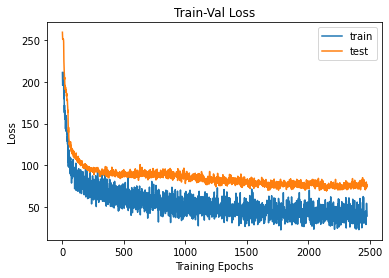

In [38]:
# num_epochs=n_epochs
plt.title("Train-Val Loss")
plt.plot(range(1,len(loss_history["train"]) + 1),loss_history["train"],label="train")
plt.plot(range(1,len(loss_history["train"]) + 1),loss_history["test"],label="test")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

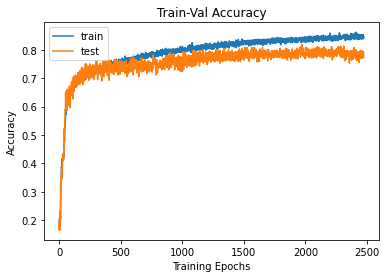

In [39]:
plt.title("Train-Val Accuracy")
plt.plot(range(1,len(acc_history["train"]) + 1),acc_history["train"],label="train")
plt.plot(range(1,len(acc_history["test"]) + 1),acc_history["test"],label="test")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()